Este notebook resolve o problema de um sistema massa-mola-amortecedor utilizando PINNs (Physics-Informed Neural Networks) com a biblioteca DeepXDE.

A equação diferencial que governa o sistema é:

\[ m \\ddot{u}(t) + c \\dot{u}(t) + k u(t) = 0 \]

Com condições iniciais:

\[
u(0) = 1 \\\\
\\dot{u}(0) = 0
\]

Parâmetros adotados:
- m = 1 (massa)
- c = 0.1 (coeficiente de amortecimento)
- k = 1 (constante da mola)


In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Parâmetros do sistema
m = 1.0
c = 0.1
k = 1.0

# EDO do sistema: m u'' + c u' + k u = 0
def pde(t, u):
    du = dde.grad.jacobian(u, t, i=0)
    ddu = dde.grad.hessian(u, t, i=0)
    return m * ddu + c * du + k * u


In [3]:
# Domínio do tempo
geom = dde.geometry.TimeDomain(0, 10)

# Condições iniciais corretas:
# u(0) = 1.0
ic1 = dde.icbc.OperatorBC(
    geom,
    lambda x, y, X: y,                     # y(0) = ?
    lambda x, on_initial: on_initial
)

# du/dt(0) = 0
ic2 = dde.icbc.OperatorBC(
    geom,
    lambda x, y, X: dde.grad.jacobian(y, x),  # dy/dx (derivada de u em t)
    lambda x, on_initial: on_initial
)

lambda x, y, X: y - 1.0




<function __main__.<lambda>(x, y, X)>

In [4]:
# Criação do objeto de dados com a PDE e condições iniciais
data = dde.data.PDE(
    geom,
    pde,
    [ic1, ic2],
    num_domain=200,
    num_boundary=2,
    solution=None,
    num_test=1000,
)


In [5]:
# Rede com 3 camadas ocultas de 50 neurônios, função de ativação tanh
net = dde.maps.FNN([1] + [50] * 3 + [1], "tanh", "Glorot uniform")


In [6]:
# Criação e compilação do modelo
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# (Opcional) Ajuste com L-BFGS
model.compile("L-BFGS")
model.train()


Compiling model...
'compile' took 1.709874 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.10e-03, 6.68e-04, 2.86e-03]    [3.14e-03, 6.68e-04, 2.86e-03]    []  
1000      [7.75e-07, 4.21e-08, 2.22e-07]    [6.95e-07, 4.21e-08, 2.22e-07]    []  
2000      [2.63e-07, 3.95e-08, 6.75e-08]    [2.52e-07, 3.95e-08, 6.75e-08]    []  
3000      [1.40e-05, 8.99e-06, 1.70e-06]    [1.42e-05, 8.99e-06, 1.70e-06]    []  
4000      [1.74e-08, 5.23e-09, 1.98e-08]    [1.71e-08, 5.23e-09, 1.98e-08]    []  
5000      [9.31e-09, 2.70e-09, 1.17e-08]    [8.95e-09, 2.70e-09, 1.17e-08]    []  

Best model at step 5000:
  train loss: 2.37e-08
  test loss: 2.33e-08
  test metric: []

'train' took 17.233662 s

Compiling model...
'compile' took 0.000153 s

Training model...

Step      Train loss                        Test loss                         Test metric
5000      [9.31e-09, 2.70e-09, 1.17e-08]    [8.95e-09, 2.70e-09, 1.17e-08]  

(<deepxde.model.LossHistory at 0x251ffb31970>,
 <deepxde.model.TrainState at 0x251ffdefb30>)

In [7]:
# Solução analítica
def sol_analitica(t_np):
    t_np = t_np.flatten()
    w_n = np.sqrt(k / m)
    zeta = c / (2 * np.sqrt(k * m))
    wd = w_n * np.sqrt(1 - zeta**2)
    return np.exp(-zeta * w_n * t_np) * np.cos(wd * t_np)

t = np.linspace(0, 10, 500).reshape(-1, 1)
u_pred = model.predict(t)
u_real = sol_analitica(t)[:, None]
erro = np.abs(u_pred - u_real)


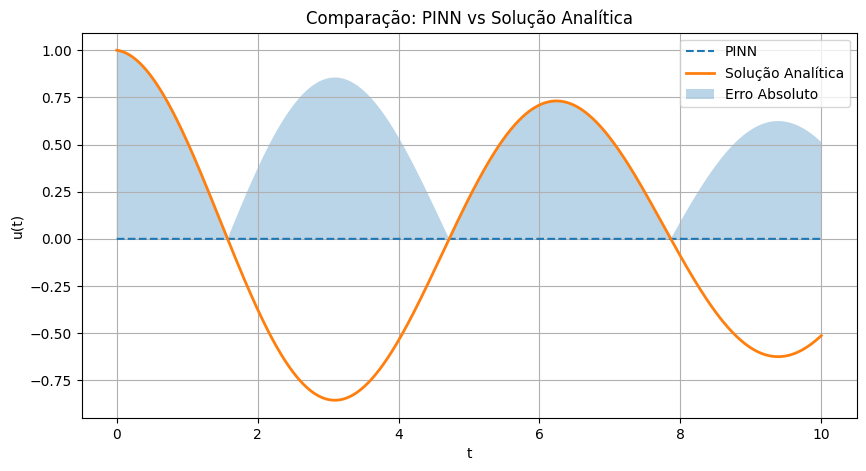

Erro absoluto médio: 0.5123577243741279


In [8]:
plt.figure(figsize=(10, 5))
plt.plot(t, u_pred, label="PINN", linestyle='--')
plt.plot(t, u_real, label="Solução Analítica", linewidth=2)
plt.fill_between(t.flatten(), erro.flatten(), alpha=0.3, label="Erro Absoluto")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Comparação: PINN vs Solução Analítica")
plt.grid(True)
plt.legend()
plt.savefig("../imagens/massa_mola_amortecedor_comparacao.png", dpi=300)
plt.show()

# Erro médio
print("Erro absoluto médio:", np.mean(erro))
